# BlueEarth Data: working with Zarr data

Notebook contains several example of converting sea level rise exposure data from multiple NetCDF files to one Zarr file


In [5]:
# Optional; code formatter, installed as jupyter lab extension
#%load_ext lab_black
# Optional; code formatter, installed as jupyter notebook extension
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [2]:
# imports
import os
import pathlib
import sys
import platform
import xarray as xr
import pandas as pd
import zarr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# make root directories importable by appending root to path
cwd = pathlib.Path().resolve()
sys.path.append(os.path.dirname(cwd))

# OS independent path configurations
if platform.system() == "Windows":
    root = pathlib.Path("C:/")
else:  # linux or other
    root = pathlib.Path("/p/")
# root = pathlib.Path().home().root
slr_impact_data_dir = pathlib.Path(root, "Users", "twigt_d", "Downloads", "_temp")

## Write Sea Level Rise impact dataset to Zarr

In [4]:
# Extreme Sea Level (JRC) paths for example how to migrate netcdf to zarr
SSP1_26_Low_present_path = slr_impact_data_dir.joinpath("Population_exposed_SLR=SSP1-2.6_CONF=Low_POP=Present_RP=100.nc")
SSP1_26_Medium_present_path = slr_impact_data_dir.joinpath("Population_exposed_SLR=SSP1-2.6_CONF=Medium_POP=Present_RP=100.nc")
SSP2_45_Medium_present_path = slr_impact_data_dir.joinpath("Population_exposed_SLR=SSP2-4.5_CONF=Medium_POP=Present_RP=100.nc")
SSP5_85_Low_present_path = slr_impact_data_dir.joinpath("Population_exposed_SLR=SSP5-8.5_CONF=Low_POP=Present_RP=100.nc")
SSP5_85_Medium_present_path = slr_impact_data_dir.joinpath("Population_exposed_SLR=SSP5-8.5_CONF=Medium_POP=Present_RP=100.nc")

SSP1_26_Low_SSP_path = slr_impact_data_dir.joinpath("Population_exposed_SLR=SSP1-2.6_CONF=Low_POP=SSP1_RP=100.nc")
SSP1_26_Medium_SSP_path = slr_impact_data_dir.joinpath("Population_exposed_SLR=SSP1-2.6_CONF=Medium_POP=SSP1_RP=100.nc")
SSP2_45_Medium_SSP_path = slr_impact_data_dir.joinpath("Population_exposed_SLR=SSP2-4.5_CONF=Medium_POP=SSP2_RP=100.nc")
SSP5_85_Low_SSP_path = slr_impact_data_dir.joinpath("Population_exposed_SLR=SSP5-8.5_CONF=Low_POP=SSP5_RP=100.nc")
SSP5_85_Medium_SSP_path = slr_impact_data_dir.joinpath("Population_exposed_SLR=SSP5-8.5_CONF=Medium_POP=SSP5_RP=100.nc")

SSP1_26_Low_present = xr.open_dataset(SSP1_26_Low_present_path)
SSP1_26_Medium_present = xr.open_dataset(SSP1_26_Medium_present_path)
SSP2_45_Medium_present = xr.open_dataset(SSP2_45_Medium_present_path)
SSP5_85_Low_present = xr.open_dataset(SSP5_85_Low_present_path)
SSP5_85_Medium_present = xr.open_dataset(SSP5_85_Medium_present_path)

SSP1_26_Low_SSP = xr.open_dataset(SSP1_26_Low_SSP_path)
SSP1_26_Medium_SSP = xr.open_dataset(SSP1_26_Medium_SSP_path)
SSP2_45_Medium_SSP = xr.open_dataset(SSP2_45_Medium_SSP_path)
SSP5_85_Low_SSP = xr.open_dataset(SSP5_85_Low_SSP_path)
SSP5_85_Medium_SSP = xr.open_dataset(SSP5_85_Medium_SSP_path)


In [8]:
slr_rcp26_present

<xarray.Dataset>
Dimensions:      (Region: 58, Year: 131, Percentile: 3)
Coordinates:
  * Region       (Region) object 'GIC' 'NWN' 'NEN' 'WNA' ... 'EIO' 'SIO' 'SOO'
  * Year         (Year) int64 2020 2021 2022 2023 2024 ... 2147 2148 2149 2150
  * Percentile   (Percentile) int64 17 50 83
    SLR          object ...
    Confidence   object ...
    Population   object ...
    Flooding     int32 ...
Data variables:
    Pop_exposed  (Region, Year, Percentile) float64 ...

<IPython.core.display.Javascript object>

In [9]:
# concat datasets along new dimension with index values and name derived from pandas index object
slr_present = xr.concat(
    [SSP1_26_Low_present, SSP1_26_Medium_present, SSP2_45_Medium_present, SSP5_85_Low_present, SSP5_85_Medium_present],
    pd.Index(["SSP1-2.6-Low", "SSP1-2.6-Medium", "SSP2-4.5-Medium", "SSP5-8.5-Low", "SSP5-8.5-Medium"], name="Projection"),
)

In [11]:
# concat datasets along new dimension with index values and name derived from pandas index object
slr_SSP = xr.concat(
    [SSP1_26_Low_SSP, SSP1_26_Medium_SSP, SSP2_45_Medium_SSP, SSP5_85_Low_SSP, SSP5_85_Medium_SSP],
    pd.Index(["SSP1-2.6-Low", "SSP1-2.6-Medium", "SSP2-4.5-Medium", "SSP5-8.5-Low", "SSP5-8.5-Medium"], name="Projection"),
)

In [12]:
slr = xr.concat(
    [slr_present, slr_SSP],
    pd.Index(["present", "SSP"], name="Population"),
)

In [13]:
# rename dimension names and re-order shape of data variables
# eessl = slr_SSP1.rename_dims({"row": "stations", "col": "rp"})
slr = slr.transpose("Projection", "Population", "Region", "Percentile", "Year")



In [38]:
# Write mapping Region and index in zarr file to csv (to use when creating geojson)
slr
slr.Region

df = slr.Region.to_dataset(name='Regions').to_dataframe()
print(df)
df.index = [x for x in range(0, len(df.values))]
header = ["Regions"]
df.to_csv('zarr_index.csv', index=True, columns = header)


        Flooding Regions
Region                  
GIC          100     GIC
NWN          100     NWN
NEN          100     NEN
WNA          100     WNA
CNA          100     CNA
ENA          100     ENA
NCA          100     NCA
SCA          100     SCA
CAR          100     CAR
NWS          100     NWS
NSA          100     NSA
NES          100     NES
SAM          100     SAM
SWS          100     SWS
SES          100     SES
SSA          100     SSA
NEU          100     NEU
WCE          100     WCE
EEU          100     EEU
MED          100     MED
SAH          100     SAH
WAF          100     WAF
CAF          100     CAF
NEAF         100    NEAF
SEAF         100    SEAF
WSAF         100    WSAF
ESAF         100    ESAF
MDG          100     MDG
RAR          100     RAR
WSB          100     WSB
ESB          100     ESB
RFE          100     RFE
WCA          100     WCA
ECA          100     ECA
TIB          100     TIB
EAS          100     EAS
ARP          100     ARP
SAS          100     SAS


In [46]:
# export to zarr in write mode (to overwrite iff exists)
slr.to_zarr(slr_impact_data_dir.joinpath("Population_exposed.zarr"), mode="w")

In [40]:
# local stored zarr
slr_check = xr.open_dataset(slr_impact_data_dir.joinpath("Population_exposed.zarr"))

C:\Users\twigt_d\Anaconda3\lib\site-packages\xarray\backends\plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
C:\Users\twigt_d\Anaconda3\lib\site-packages\xarray\backends\plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


Text(0, 0.5, 'Population exposed')

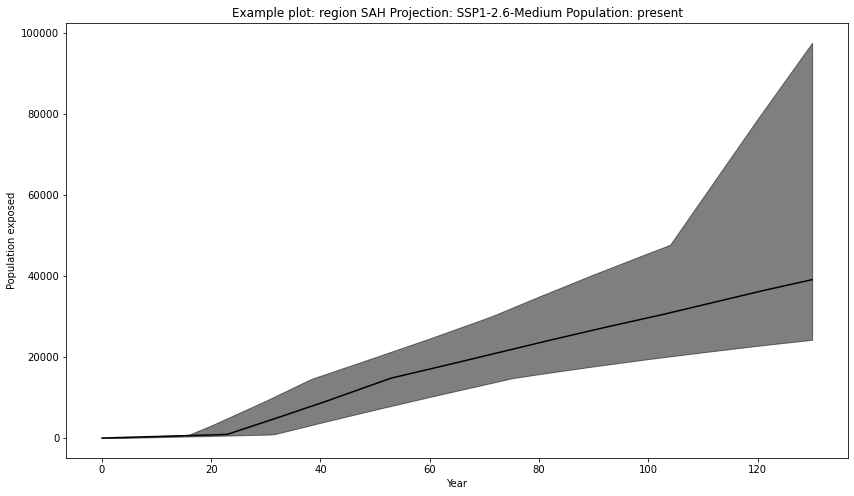

In [44]:
# slr_check.isel(Region=1, Percentile=0, scenario=0, population=0)["Pop_exposed"].plot()

region_id = 20
projection_id = 1
population_id = 0

lb = slr_check.isel(
    Region=region_id, Percentile=0, Projection=projection_id, Population=population_id
)["Pop_exposed"]
mean = slr_check.isel(
    Region=region_id, Percentile=1, Projection=projection_id, Population=0
)["Pop_exposed"]
ub = slr_check.isel(
    Region=region_id, Percentile=2, Projection=projection_id, Population=population_id
)["Pop_exposed"]

fig = plt.figure(1, figsize=(14, 8))
plt.fill_between(range(mean.shape[0]), ub, lb, color="k", alpha=0.5)
plt.plot(mean, "k")
plt.title(
    "Example plot: region "
    + str(slr_check.Region[region_id].values)
    + " Projection: "
    + str(slr_check.Projection[projection_id].values)
    + " Population: "
    + str(slr_check.Population[population_id].values)
)
plt.xlabel("Year")
plt.ylabel("Population exposed")

In [10]:
# cloud stored zarr with zarr

g = zarr.open_group(
    "gs://dgds-data-public/coclico/CoastAlRisk_Europe_EESSL.zarr",
    storage_options={"anon": True},
)

g.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.FSStore
No. members,5
No. arrays,5
No. groups,0
Arrays,"RP, latitude, longitude, scenario, ssl"


<IPython.core.display.Javascript object>

In [4]:
# cloud stored zarr with xarray
ds_gcs = xr.open_dataset(
    "gs://dgds-data-public/coclico/CoastAlRisk_Europe_EESSL.zarr",
    backend_kwargs={"storage_options": {"project": "coclico", "token": None}},
    engine="zarr",
)

ds_gcs.info


<bound method Dataset.info of <xarray.Dataset>
Dimensions:    (RP: 8, stations: 2242, scenario: 3)
Coordinates:
  * RP         (RP) float32 5.0 10.0 20.0 50.0 100.0 200.0 500.0 1e+03
    latitude   (stations) float64 ...
    longitude  (stations) float64 ...
  * scenario   (scenario) object 'Historical' 'RCP45' 'RCP85'
Dimensions without coordinates: stations
Data variables:
    ssl        (scenario, stations, RP) float64 ...
Attributes:
    Institution:      Joint European Research Center, Institute of Environmen...
    Project Acronym:  CoastAlRisk
    Project Name:     Prototype of a first Global Integrated Coastal Impact-b...
    disclaimer:       Unless the following would not be permitted or valid un...
    email:            michail.vousdoukas@ec.europa.eu
    reference:        Vousdoukas MI, Voukouvalas E, Annunziato A, Giardino A,...
    terms_for_use:    European Union, 1995-2015.\nReuse is authorised, provid...
    title:            European extreme storm surge level
    vers